
Example of bayesian optimization for a 1d function from scratch
First, import the packages

In [1]:
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

Objective function; simulated objective

In [2]:
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return (x ** 2 * sin(5 * pi * x) ** 6.0) + noise

In [3]:
# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)


In [4]:
# UCB (upper confidence bound) acquisition function
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    #mu = mu[:, 0]
    # Option1: calculate the probability of improvement
    #scores = norm.cdf((mu - best) / (std + 1E-9))
    # Option2: calculate the upper confidence bound
    scores = mu + 1.0*std
    return scores


In [5]:
# optimize the acquisition function
def opt_acquisition(X, y, model):
    # random search, generate random samples
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix, 0]


In [6]:
# plot real observations vs surrogate function
def plot(X, y, model, img_name='plot'):
    # scatter plot of inputs and real objective function
    pyplot.scatter(X, y)
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    # show the plot
    #pyplot.show()
    pyplot.savefig(img_name + '.png')



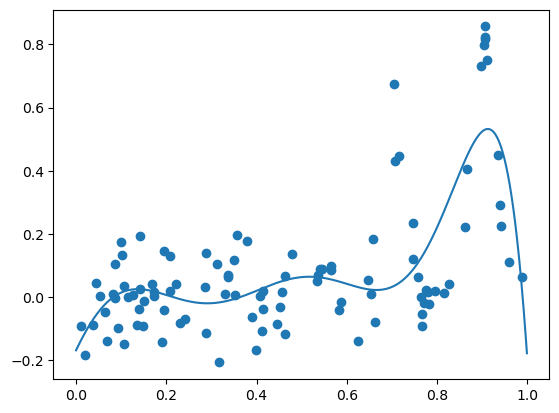

In [24]:
# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model,  img_name='gp_initial_model')


In [27]:
# perform the optimization process
for i in range(100):
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    # sample the point
    actual = objective(x)
    # summarize the finding
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est[0], actual))
    # add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)


>x=0.923, f()=0.689989, actual=0.616
>x=0.913, f()=0.702452, actual=0.826
>x=0.917, f()=0.700387, actual=0.678
>x=0.897, f()=0.694782, actual=0.859
>x=0.917, f()=0.703072, actual=0.730
>x=0.906, f()=0.707263, actual=0.929
>x=0.902, f()=0.707673, actual=0.951
>x=0.906, f()=0.714662, actual=0.883
>x=0.910, f()=0.717639, actual=0.810
>x=0.907, f()=0.718871, actual=0.927
>x=0.888, f()=0.692172, actual=0.688
>x=0.920, f()=0.711165, actual=0.556
>x=0.902, f()=0.716817, actual=0.848
>x=0.916, f()=0.716325, actual=0.715
>x=0.904, f()=0.720807, actual=0.735
>x=0.890, f()=0.699881, actual=0.669
>x=0.908, f()=0.721632, actual=0.805
>x=0.908, f()=0.722716, actual=0.778
>x=0.904, f()=0.721827, actual=0.920
>x=0.909, f()=0.725966, actual=0.678
>x=0.906, f()=0.724999, actual=1.030
>x=0.893, f()=0.712461, actual=0.713
>x=0.903, f()=0.727661, actual=0.740
>x=0.901, f()=0.726276, actual=0.783
>x=0.912, f()=0.728451, actual=0.687
>x=0.897, f()=0.721197, actual=0.818
>x=0.906, f()=0.730520, actual=0.868
>

Best Result: x=0.905, y=1.070


/var/folders/w8/y296_yqn78bb62_nvf0k7vbsj3r94s/T/ipykernel_28228/2547455244.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))


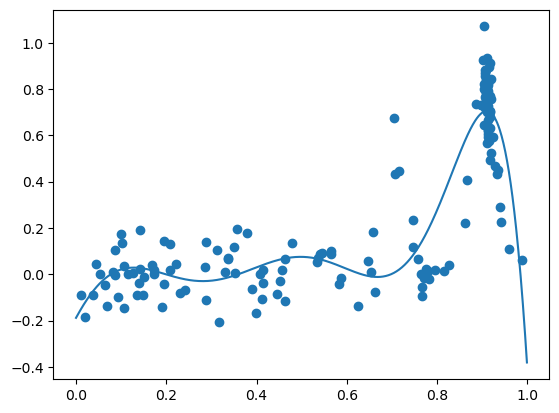

In [26]:
# plot all samples and the final surrogate function
plot(X, y, model,  img_name='gp_result_model')
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))
